# Evaluate metric on overfitted model

Check other overfitting module for more details


In [1]:
import random

import keras.models
from skimage.io import imshow

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from tools import sources
from tools import unetmodel
from tools import rect
from tools import unet_ext_masks


from skimage.transform import resize

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
def show_imgs(imgs, titles=None):
    n = len(imgs)
    _, axs = plt.subplots(ncols=n, figsize=(15, 5))
    
    for ix, ax in enumerate(axs):
        ax.imshow(imgs[ix])
        ax.axis('off')
        
        if titles:
            ax.set_title(titles[ix])

In [3]:
# Loading 8 images of reference data

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

ztx, zty, ztc, ztdx1, ztdy1, ztdx2, ztdy2, ztrm, ztmw, _ = sources.flattened_trainset_ex_2(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS, 8)

100%|██████████| 8/8 [00:01<00:00,  7.43it/s]


In [4]:
zty.shape, ztmw.shape

((8, 128, 128, 1), (8, 128, 128, 1))

In [5]:
np.concatenate([zty, ztmw], axis=-1).shape

(8, 128, 128, 2)

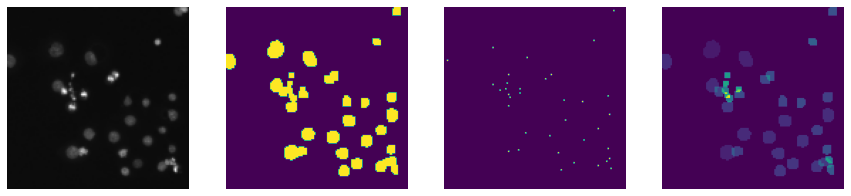

In [6]:
# Look at input, ground truth and computed nuclei center for first image

ix = 0
show_imgs([ztx[ix], zty[ix], ztc[ix], ztmw[ix]])

In [7]:
# Compile to False because testing is not needed
# This way custom loss functions are not needed
model_ext_2 = keras.models.load_model(sources.MODEL_PATH + '/model-dsbowl2018-unet-ext_2.h5', compile=False)

In [8]:
pty, ptc, ptdx1, ptdy1, ptdx2, ptdy2 = model_ext_2.predict(ztx)

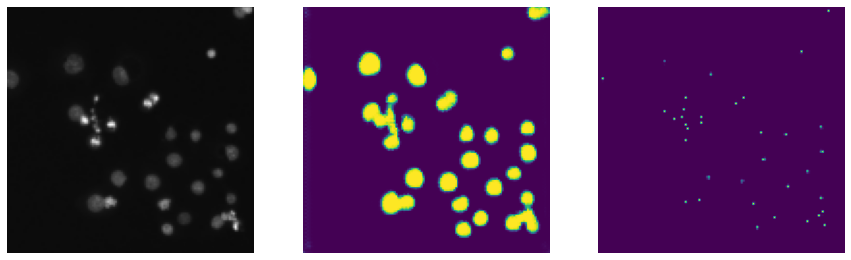

In [9]:
# Look at input, predicted masks, centers and overlaps (the latter is not used)

show_imgs([ztx[ix], pty[ix], ptc[ix]])

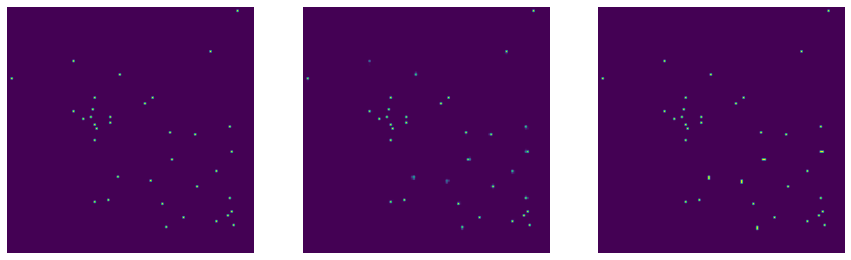

In [69]:
show_imgs([ztc[ix], ptc[ix], ptc[ix]>=0.2])

# Rectangles

In [92]:
rects = unet_ext_masks.get_rects_from_centers(ptc[ix], ptdx1[ix], ptdx2[ix], ptdy1[ix], ptdy2[ix], 0.2)

In [93]:
len(rects)

41

In [95]:
rects = rect.merge(rects)
len(rects)

36

In [96]:
import matplotlib.patches as patches

def show_rects(rects, ix, zty):
    # Create figure and axes
    fig,ax = plt.subplots(1)

    # Display the image
    ax.imshow(zty[ix])

    for (x1, y1, x2, y2) in rects:
        # Create a Rectangle patch and add patch to Axes
        ax.add_patch(patches.Rectangle((x1,y1),int(x2-x1+1),int(y2-y1+1),linewidth=1,edgecolor='r',facecolor='none'))

    plt.show()

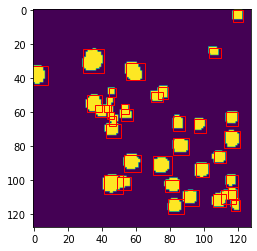

In [97]:
show_rects(rects, ix, zty)

In [98]:
masks = unet_ext_masks.extract_masks(pty[ix], rects, thr=0.35)

In [99]:
unet_ext_masks.precision_iou(ztrm[ix], masks)

0.4280126372061058

In [100]:
ious = unet_ext_masks.agg_iou(ztrm[ix], masks, thr=0.5)

0.9381443298969072


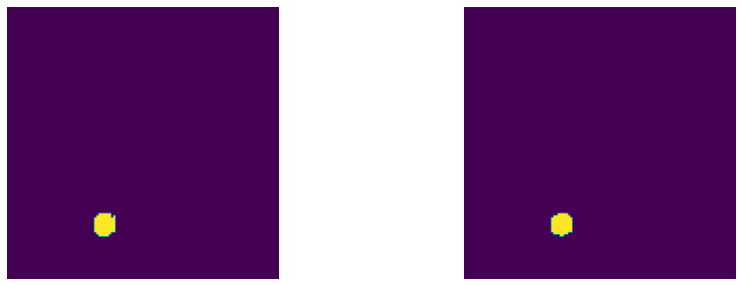

In [101]:
z, p, iou = ious[0]
print(iou)
show_imgs([masks[p], ztrm[ix][z]])

0.8309859154929577


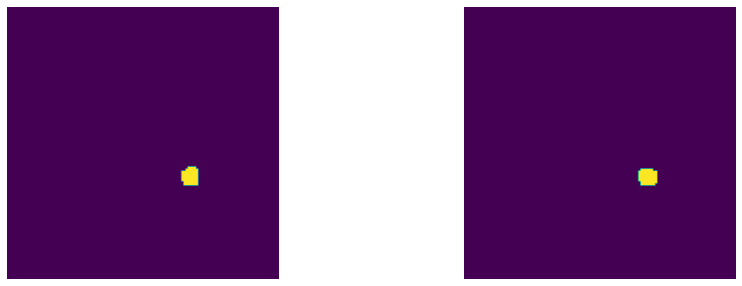

In [102]:
z, p, iou = ious[15]
print(iou)
show_imgs([masks[p], ztrm[ix][z]])

In [103]:
ious, len(ious)

([(12, 9, 0.9381443298969072),
  (9, 21, 0.9347826086956522),
  (25, 14, 0.9342105263157895),
  (28, 2, 0.9333333333333333),
  (20, 32, 0.9230769230769231),
  (6, 15, 0.9032258064516129),
  (5, 17, 0.9),
  (15, 28, 0.896551724137931),
  (10, 1, 0.8943089430894309),
  (2, 8, 0.8620689655172413),
  (16, 23, 0.8620689655172413),
  (13, 25, 0.8571428571428571),
  (19, 30, 0.8478260869565217),
  (27, 31, 0.8450704225352113),
  (17, 3, 0.8333333333333334),
  (30, 22, 0.8309859154929577),
  (22, 20, 0.8166666666666667),
  (34, 16, 0.8048780487804879),
  (4, 26, 0.7941176470588235),
  (33, 27, 0.7708333333333334),
  (35, 24, 0.75),
  (23, 13, 0.7272727272727273),
  (18, 35, 0.725),
  (1, 11, 0.7166666666666667),
  (31, 18, 0.7142857142857143),
  (32, 34, 0.6774193548387096),
  (21, 19, 0.6774193548387096),
  (8, 29, 0.6615384615384615),
  (7, 6, 0.631578947368421),
  (11, 5, 0.5882352941176471),
  (0, 12, 0.5),
  (26, 7, 0.47058823529411764),
  (29, 33, 0.4444444444444444),
  (14, 10, 0.275862

In [83]:
unet_ext_masks.agg_iou([zty[ix]], [pty[ix]], thr=0.5) # Threshold used when making sub masks

[(0, 0, 0.8589324618736384)]

In [84]:
unet_ext_masks.agg_iou([zty[ix]], [pty[ix]], thr=0.35)

[(0, 0, 0.850131926121372)]

## Finding the images with lowest IOUs

In [119]:
ious = unet_ext_masks.agg_iou(ztrm[ix], masks, thr=0.35)

[(14, 10, 0.12), (0, 12, 0.0)]


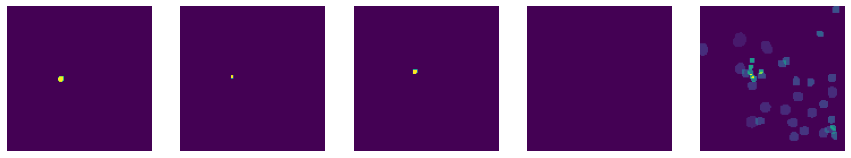

In [120]:
# Lowest 2
lowest = ious[-2:]
print(lowest)
imgs = [im for gt_ix, p_ix, _ in lowest for im in [ztrm[ix][gt_ix], masks[p_ix]] ]
show_imgs(imgs + [ztmw[ix]])

[(7, 6, 0.3125), (24, 4, 0.24242424242424243)]


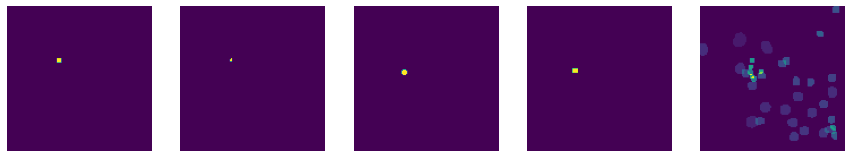

In [121]:
# Next 2
lowest = ious[-4:-2]
print(lowest)
imgs = [im for gt_ix, p_ix, _ in lowest for im in [ztrm[ix][gt_ix], masks[p_ix]] ]
show_imgs(imgs + [ztmw[ix]])